In [99]:
import os
import inspect
import csv as csv
import re
import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import _tree, DecisionTreeRegressor, plot_tree
import seaborn as sns
from sklearn.metrics import (
    log_loss,
    accuracy_score,
    confusion_matrix,
    precision_recall_fscore_support,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

import xgboost as xgb

# Define the input and output file paths
cwd = inspect.getfile(inspect.currentframe())
cwd = os.path.dirname(os.path.abspath(cwd))

print(cwd)

input_file = cwd + "psam_p06.csv"
output_file = os.path.join(os.path.expanduser("~"), "Downloads", "pca.csv")


# List of fields to be copied
fields_to_copy = [
    "SERIALNO",
    "SPORDER",
    "WAGP",
    "AGEP",
    "COW",
    "SCHL",
    "SEX",
    "WKHP",
    "ESR",
    "NAICSP",
    "RAC1P",
    "INDP",
    "OCCP",
    "SCIENGP",
    "SCIENGRLP",
    "SOCP",
]

# Open the input CSV file for reading
with open("psam_p06.csv") as infile:
    csv_reader = csv.DictReader(infile)

    # Open the output CSV file for writing
    with open(output_file, mode="w", newline="", encoding="utf-8") as outfile:
        # Create a CSV writer object
        csv_writer = csv.DictWriter(outfile, fieldnames=fields_to_copy)

        # Write header row to the output file
        csv_writer.writeheader()
        print(f"processing...")
        # Iterate over rows in the input file
        nRows = 0
        nWritten = 0
        for row in csv_reader:
            if nRows % 10000 == 0:
                print(".", end="", flush=True)
            # Create a new row with only the selected fields
            filtered_row = {field: row[field] for field in fields_to_copy}
            if (
                filtered_row["WAGP"] != ""
                and filtered_row["AGEP"] != ""
                and filtered_row["SCHL"] != ""
                and filtered_row["SEX"] != ""
                and float(filtered_row["WAGP"])
                > 0  # filter for records where wages are > 0 (current earners)
                and int(filtered_row["AGEP"]) >= 18  # age 18 or older
                and float(filtered_row["WAGP"])
                < 684000  # exclude top-coded wages (cutoff)
            ):
                if int(filtered_row["SCHL"]) <= 15:
                    filtered_row["SCHL"] = "15"  # anyone without at least a HS diploma
                elif int(filtered_row["SCHL"]) <= 19:
                    filtered_row["SCHL"] = (
                        "19",
                    )  # anyone with at least HS but less than Associate Degree
                # some values for NAICSP/SOCP/SCIENGP/SCIENGRLP have alphanumeric
                # Use regex to replace non-numeric characters with '0'
                # replacing with zero doesn't seem to create any duplicates/collisions with other values
                filtered_row["NAICSP"] = re.sub(r"[^0-9]", "0", filtered_row["NAICSP"])
                filtered_row["SOCP"] = re.sub(r"[^0-9]", "0", filtered_row["SOCP"])
                filtered_row["SCIENGP"] = re.sub(
                    r"[^0-9]", "0", filtered_row["SCIENGP"]
                )
                filtered_row["SCIENGRLP"] = re.sub(
                    r"[^0-9]", "0", filtered_row["SCIENGRLP"]
                )

                # Write the filtered row to the output file
                csv_writer.writerow(filtered_row)
                nWritten += 1
            nRows += 1

print(f"\ndone creating {output_file}, accepted {nWritten} lines out of {nRows}")

C:\Users\rohan\AppData\Local\Temp\ipykernel_17616
processing...
........................................
done creating C:\Users\rohan\Downloads\pca.csv, accepted 186375 lines out of 392318


In [28]:
df = pd.read_csv('ipykernel_17616pca.csv')
df.head()

,SERIALNO,SPORDER,WAGP,AGEP,COW,SCHL,SEX,WKHP,ESR,NAICSP,RAC1P,INDP,OCCP,SCIENGP,SCIENGRLP,SOCP
0,2023GQ0000009,1,3600,19,1,"('19',)",2,16,1,7220,8,8680,4055,NaN,NaN,353023
1,2023GQ0000028,1,800,23,1,"('19',)",1,15,1,7115,1,8564,2850,NaN,NaN,273043
2,2023GQ0000052,1,1800,23,1,20,1,15,1,7115,1,8564,2850,NaN,NaN,273043
3,2023GQ0000125,1,65000,28,1,"('19',)",1,40,6,4492,9,4796,4760,NaN,NaN,412031
4,2023GQ0000152,1,3000,20,1,"('19',)",2,20,6,61101,2,7870,4640,NaN,NaN,399041


## NUMERIC CONVERSION

In [29]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df.dtypes

SERIALNO     float64
SPORDER        int64
WAGP           int64
AGEP           int64
COW            int64
SCHL         float64
SEX            int64
WKHP           int64
ESR            int64
NAICSP         int64
RAC1P          int64
INDP           int64
OCCP           int64
SCIENGP      float64
SCIENGRLP    float64
SOCP           int64
dtype: object

## KNN - can be useful but time consuming

In [113]:
# copy dataframe, ensure all types are int or float
dfKNN = df.copy()
dfKNN.head()
# drop serialno, sciengp, and sciengrlp since all Nan 
X = dfKNN.drop(columns = ['WAGP', 'SERIALNO', 'SCIENGP', 'SCIENGRLP'])
y = dfKNN['WAGP']
# drop remaining NaN values which are from SCHL
X = X.dropna()
y = y[X.index]
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 1234)
# standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
# train KNN model
knn = KNeighborsRegressor(n_neighbors = 10) # tune k 
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

mae10 = mean_absolute_error(y_test, y_pred)
mse10 = mean_squared_error(y_test, y_pred)
rmse10 = np.sqrt(mse10)

print(f"Mean Absolute Error: {mae10}")
print(f"Root Mean Squared Error: {rmse10}")

Mean Absolute Error: 37441.47510255039
Root Mean Squared Error: 55359.01065983489


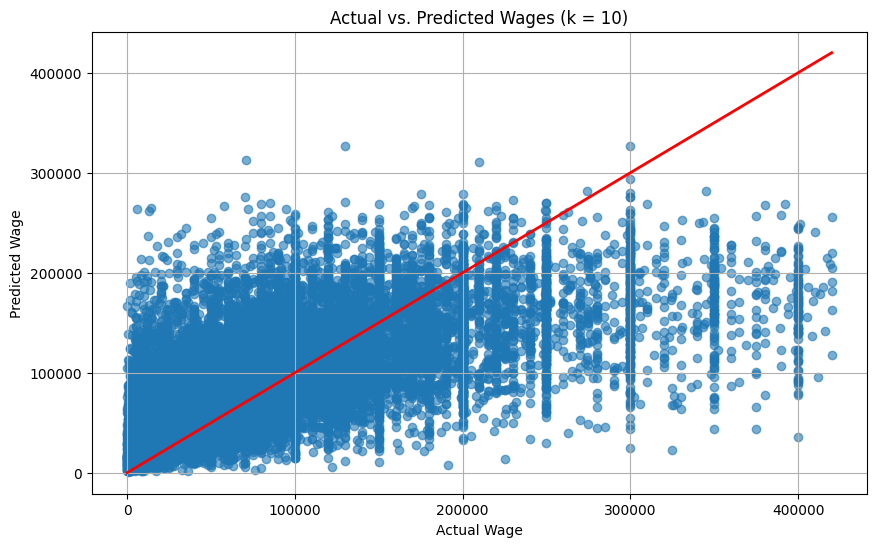

In [9]:
y_pred = knn.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)  # Diagonal reference line
plt.title('Actual vs. Predicted Wages (k = 10)')
plt.xlabel('Actual Wage')
plt.ylabel('Predicted Wage')
plt.grid(True)
plt.show()


Mean Absolute Error: 38170.41023096129
Root Mean Squared Error: 55284.30229177852


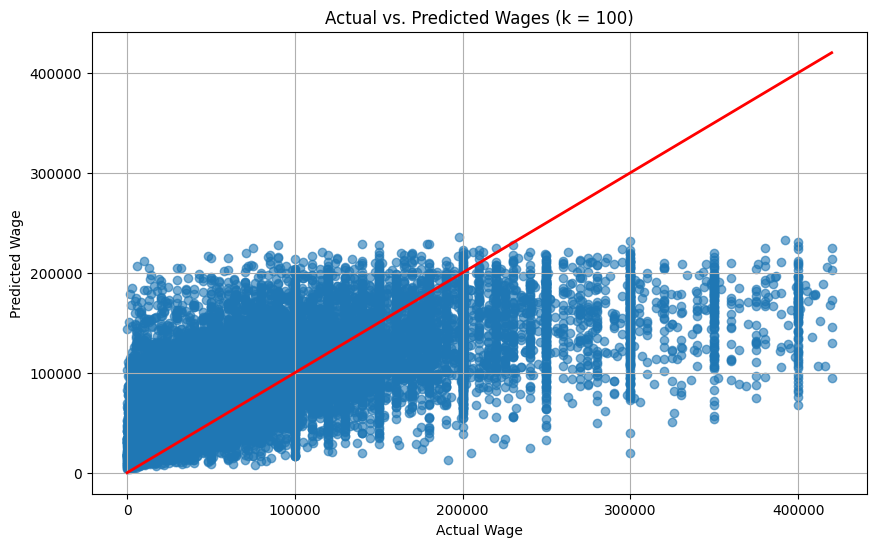

In [10]:
knn100 = KNeighborsRegressor(n_neighbors = 100) # tune k 
knn100.fit(X_train, y_train)

y_pred100 = knn100.predict(X_test)

mae100 = mean_absolute_error(y_test, y_pred100)
mse100 = mean_squared_error(y_test, y_pred100)
rmse100 = np.sqrt(mse100)

print(f"Mean Absolute Error: {mae100}")
print(f"Root Mean Squared Error: {rmse100}")
y_pred100 = knn100.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred100, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)  # Diagonal reference line
plt.title('Actual vs. Predicted Wages (k = 100)')
plt.xlabel('Actual Wage')
plt.ylabel('Predicted Wage')
plt.grid(True)
plt.show()


Mean Absolute Error: 66375.1171872659
Root Mean Squared Error: 86247.40559650333


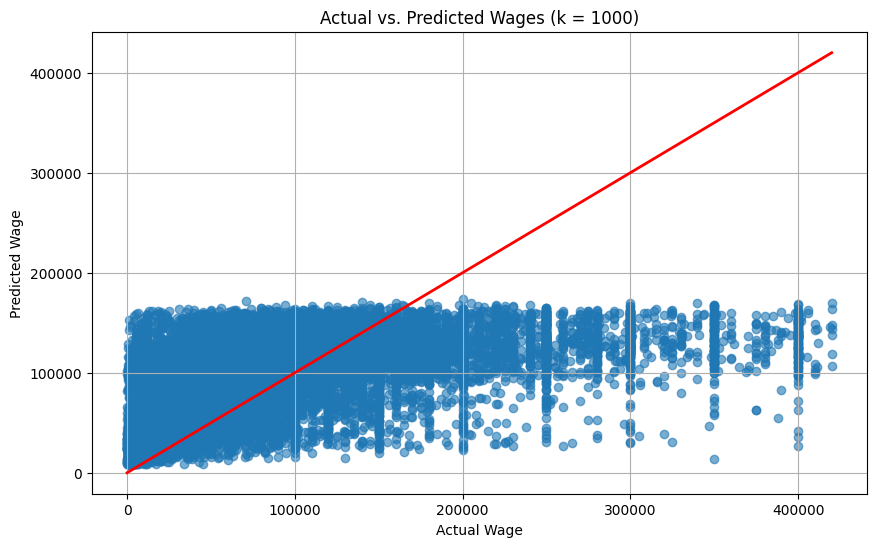

In [79]:
knn1000 = KNeighborsRegressor(n_neighbors = 1000) # tune k 
knn1000.fit(X_train, y_train)

y_pred1000 = knn1000.predict(X_test)

mae1000 = mean_absolute_error(y_test, y_pred100)
mse1000 = mean_squared_error(y_test, y_pred100)
rmse1000 = np.sqrt(mse1000)

print(f"Mean Absolute Error: {mae1000}")
print(f"Root Mean Squared Error: {rmse1000}")
y_pred1000 = knn1000.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred1000, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)  # Diagonal reference line
plt.title('Actual vs. Predicted Wages (k = 1000)')
plt.xlabel('Actual Wage')
plt.ylabel('Predicted Wage')
plt.grid(True)
plt.show()


In [82]:
r2_1000 = r2_score(y_test, y_pred1000)  
r2_100 = r2_score(y_test, y_pred100)
r2 = r2_score(y_test, y_pred)
print(f"R-squared for KNN with 10 neighbors: {r2:.4f}")
print(f"R-squared for KNN with 100 neighbors: {r2_100:.4f}")
print(f"R-squared for KNN with 1000 neighbors: {r2_1000:.4f}")

R-squared for KNN with 10 neighbors: -0.7323
R-squared for KNN with 100 neighbors: -0.3426
R-squared for KNN with 1000 neighbors: 0.3187


## Decision Tree Regressor - OK, interesting to explore how metrics and routes are influenced by increasing depth/num of trees

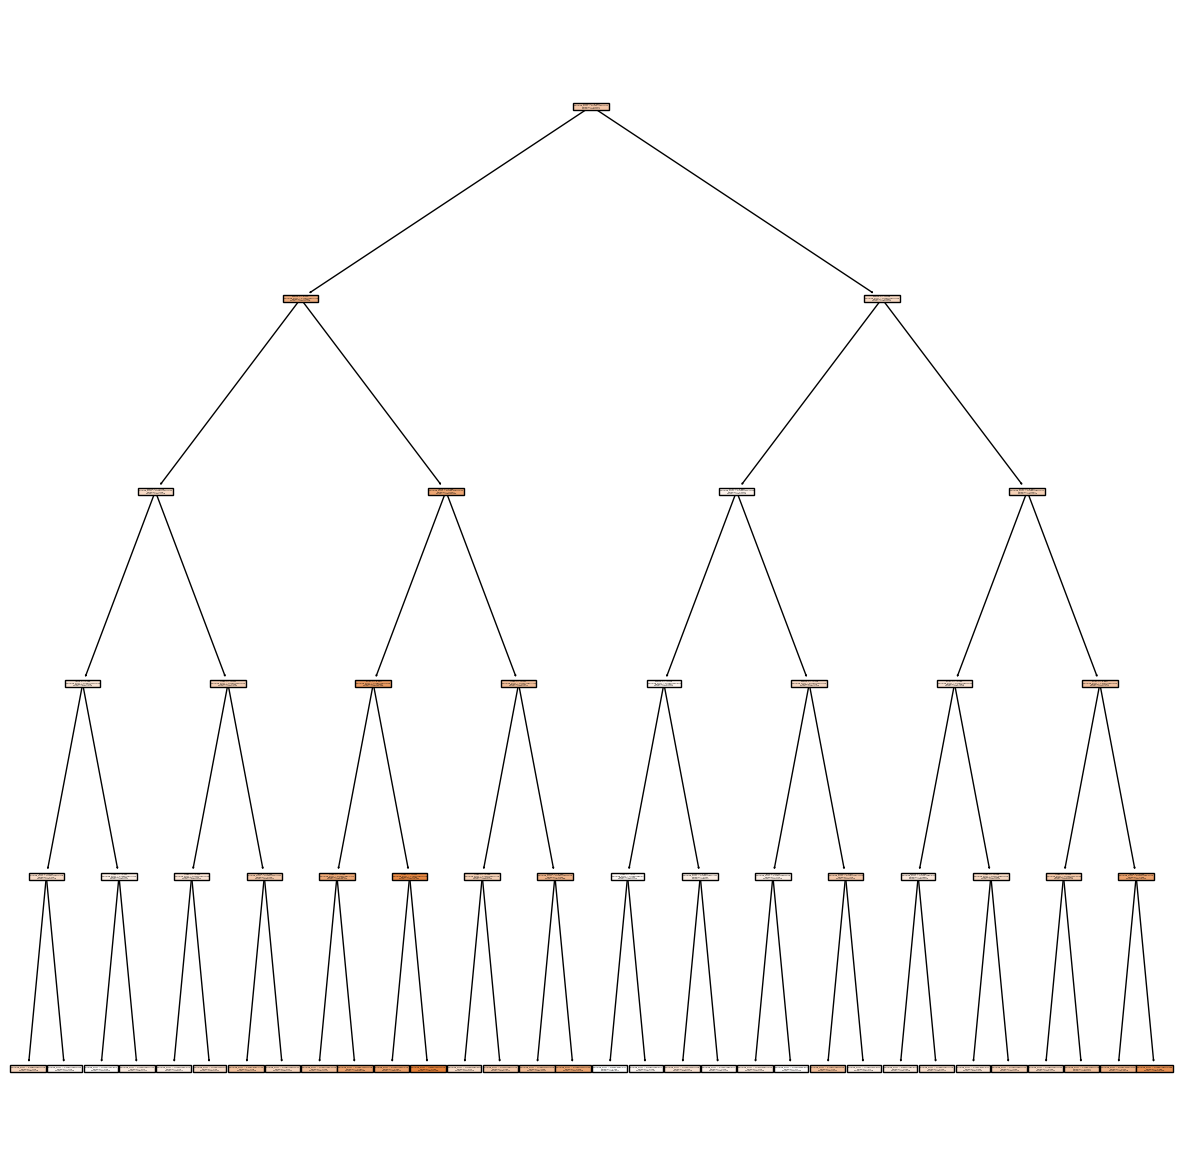

In [117]:
# copy dataframe, ensure all types are int or float
dfTree = df.copy()
# drop serialno, sciengp, and sciengrlp since all Nan 
X = dfTree.drop(columns = ['WAGP', 'SERIALNO', 'SCIENGP', 'SCIENGRLP'])
y = dfTree['WAGP']
# drop remaining NaN values which are from SCHL
X = X.dropna()
y = y[X.index]
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 1234)
# standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
treeModel = DecisionTreeRegressor(max_depth=5) # need bigger forest for good meaning. decision trees may not be a great option
# as we increase depth the following feature ipmortance and routes are also updated. will be something interesting to explore
treeModel.fit(X_train, y_train)
plt.figure(figsize=(15, 15))
plot_tree(treeModel, feature_names=X.columns, filled=True)
plt.show()


In [118]:
def get_leaf_paths(tree, feature_names):
    paths = []
    values = []

    def traverse(node, path):
        if tree.children_left[node] == -1:  # Leaf node
            paths.append(" -> ".join(path))
            values.append(tree.value[node].flatten()[0])
            return
        feature = feature_names[tree.feature[node]]
        threshold = tree.threshold[node]
        
        traverse(tree.children_left[node], path + [f"{feature} <= {threshold:.2f}"])
        traverse(tree.children_right[node], path + [f"{feature} > {threshold:.2f}"])

    traverse(0, [])
    return paths, values

feature_names = X.columns
paths, leaf_values = get_leaf_paths(treeModel.tree_, feature_names)

for path, value in zip(paths, leaf_values):
    print(f"Rule: {path} -> Predicted Value: {value}")

Rule: OCCP <= -0.44 -> WKHP <= 0.07 -> WKHP <= -1.18 -> INDP <= 0.39 -> ESR <= 0.20 -> Predicted Value: 64859.068322981366
Rule: OCCP <= -0.44 -> WKHP <= 0.07 -> WKHP <= -1.18 -> INDP <= 0.39 -> ESR > 0.20 -> Predicted Value: 21793.23943661972
Rule: OCCP <= -0.44 -> WKHP <= 0.07 -> WKHP <= -1.18 -> INDP > 0.39 -> AGEP <= -1.13 -> Predicted Value: 14730.854271356784
Rule: OCCP <= -0.44 -> WKHP <= 0.07 -> WKHP <= -1.18 -> INDP > 0.39 -> AGEP > -1.13 -> Predicted Value: 35806.41697877653
Rule: OCCP <= -0.44 -> WKHP <= 0.07 -> WKHP > -1.18 -> AGEP <= -0.84 -> AGEP <= -1.34 -> Predicted Value: 31468.35
Rule: OCCP <= -0.44 -> WKHP <= 0.07 -> WKHP > -1.18 -> AGEP <= -0.84 -> AGEP > -1.34 -> Predicted Value: 55216.89655172414
Rule: OCCP <= -0.44 -> WKHP <= 0.07 -> WKHP > -1.18 -> AGEP > -0.84 -> INDP <= 0.47 -> Predicted Value: 92229.33551198257
Rule: OCCP <= -0.44 -> WKHP <= 0.07 -> WKHP > -1.18 -> AGEP > -0.84 -> INDP > 0.47 -> Predicted Value: 64621.3470681458
Rule: OCCP <= -0.44 -> WKHP > 

In [119]:
y_pred = treeModel.predict(X_test)

# Calculate errors
maeTree = mean_absolute_error(y_test, y_pred)
mseTree = mean_squared_error(y_test, y_pred)
rmseTree = np.sqrt(mseTree)
r2Tree = r2_score(y_test, y_pred)
r2Tree_scores = cross_val_score(treeModel, X_train, y_train, scoring="r2", cv=5)
print(f"Mean Absolute Error (MAE): {maeTree:.2f}")
print(f"Mean Squared Error (MSE): {mseTree:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmseTree:.2f}")
print(f"R² Score: {r2Tree:.2f}")

print(f"Cross-Validated R² Scores: {r2Tree_scores}")
print(f"Mean R² Score: {r2Tree_scores.mean():.2f}")

Mean Absolute Error (MAE): 40133.93
Mean Squared Error (MSE): 3401474838.64
Root Mean Squared Error (RMSE): 58322.16
R² Score: 0.37
Cross-Validated R² Scores: [0.37447972 0.37656092 0.38461913 0.37921928 0.36614725]
Mean R² Score: 0.38


### Tuning

In [57]:
param_grid = {
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=1234), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train model with best params
treeModel = DecisionTreeRegressor(**best_params, random_state=1234)
treeModel.fit(X_train, y_train)

Best Hyperparameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}


DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      random_state=1234)

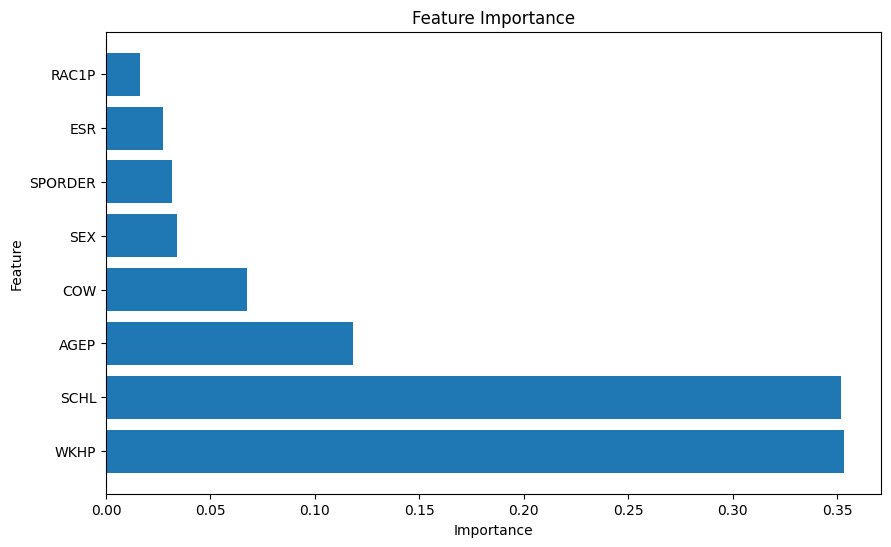

In [58]:
importances = treeModel.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

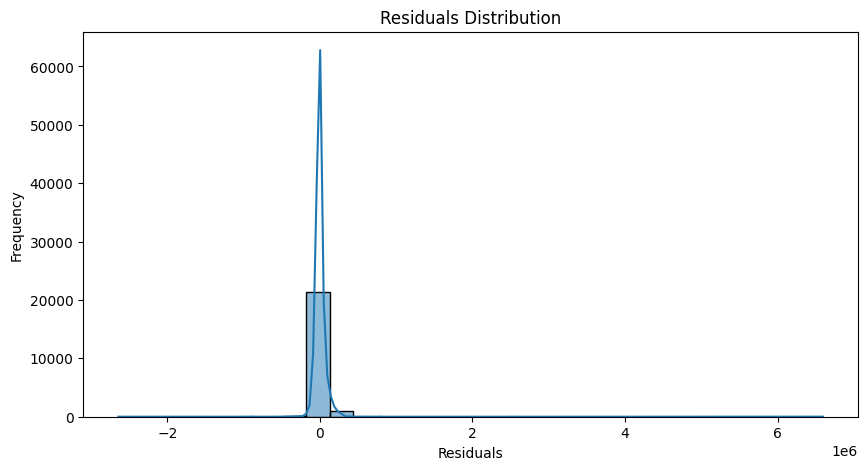

In [60]:
residuals = y_test - y_pred

plt.figure(figsize=(10,5))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()
# if centered around 0 the model is unbiased

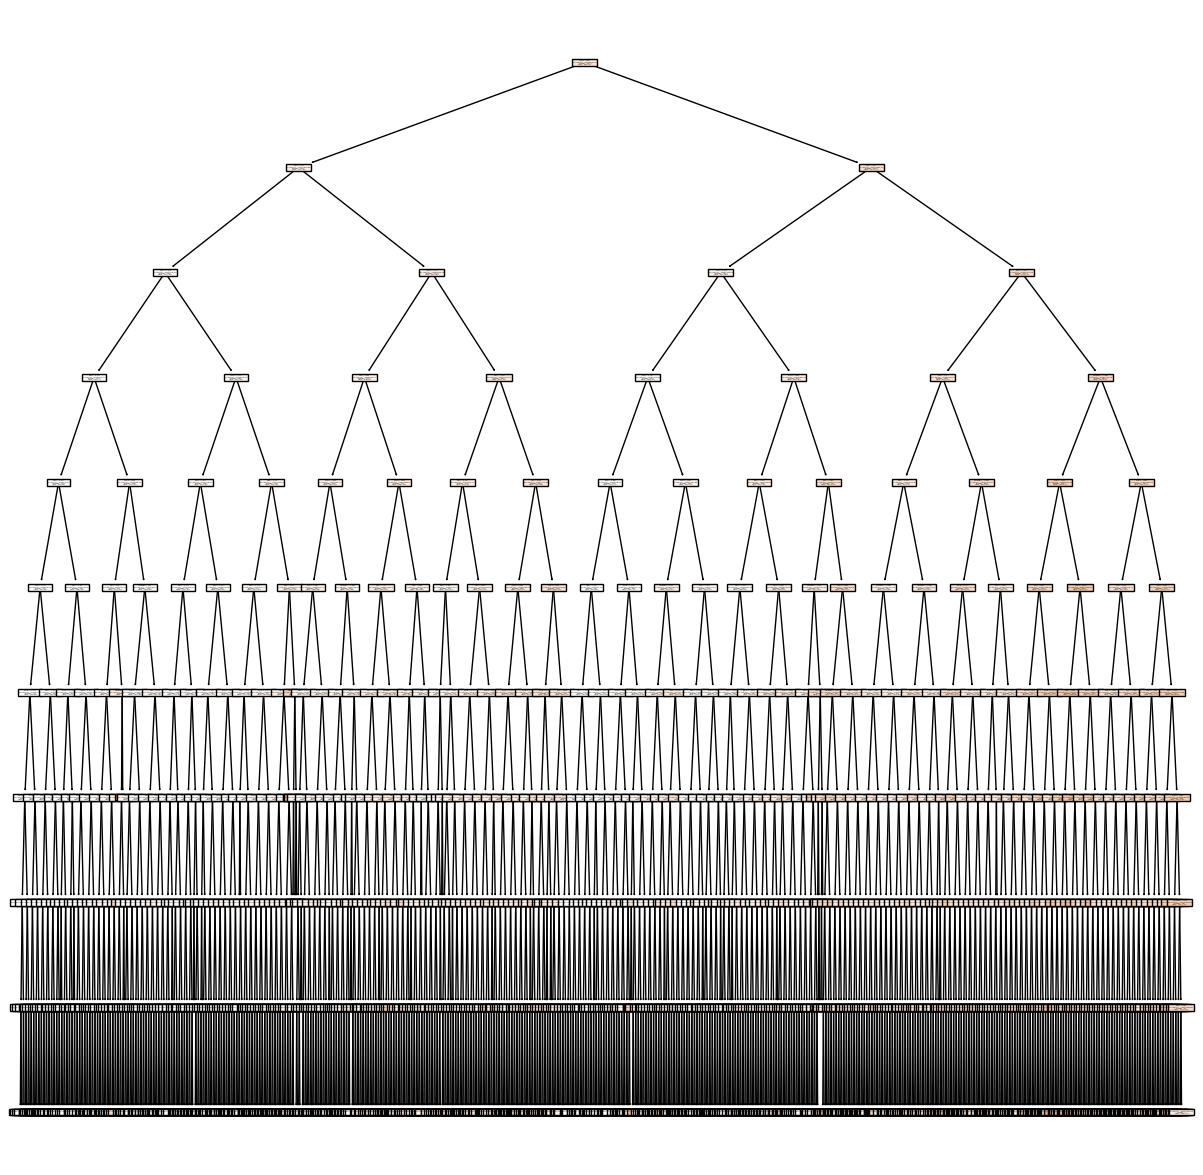

In [61]:
# new plot only using significant features and suggested tree depth 
# copy dataframe, ensure all types are int or float
dfTree2 = df.copy()
# drop serialno, sciengp, and sciengrlp since all Nan 
important_features = ['WKHP', 'SCHL', 'AGEP', 'COW', 'SEX', 'SPORDER']
X2 = dfTree2[important_features]
y2 = dfTree2['WAGP']
# drop remaining NaN values which are from SCHL
X2 = X2.dropna()
y2 = y2[X2.index]
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = 0.2, random_state= 1234)
# standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
treeModel = DecisionTreeRegressor(max_depth=10) # need bigger forest for good meaning. decision trees may not be a great option
# as we increase depth the following feature ipmortance and routes are also updated. will be something interesting to explore
treeModel.fit(X_train, y_train)
plt.figure(figsize=(15, 15))
plot_tree(treeModel, feature_names=X.columns, filled=True)
plt.show()


In [62]:
y_pred = treeModel.predict(X_test)

# Calculate errors
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
r2_scores = cross_val_score(treeModel, X_train, y_train, scoring="r2", cv=5)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

print(f"Cross-Validated R² Scores: {r2_scores}")
print(f"Mean R² Score: {r2_scores.mean():.2f}")

Mean Absolute Error (MAE): 39379.01
Mean Squared Error (MSE): 3335571292.74
Root Mean Squared Error (RMSE): 57754.40
R² Score: 0.38
Cross-Validated R² Scores: [0.39197248 0.36859941 0.3833846  0.38504716 0.37574062]
Mean R² Score: 0.38


#### Conclusion: decision trees will not be helpful. after tuning and using suggested importnt hyperparameters we can see the metrics have not changed

## Polynomial Regression - easiest to work with and understand. will be good high level model that can serve as introduction to modeling component

Polynomial Regression (Degree 3)
Mean Squared Error: 3551758167.53
Mean Absolute Error: 41099.44
R² Score: 0.36


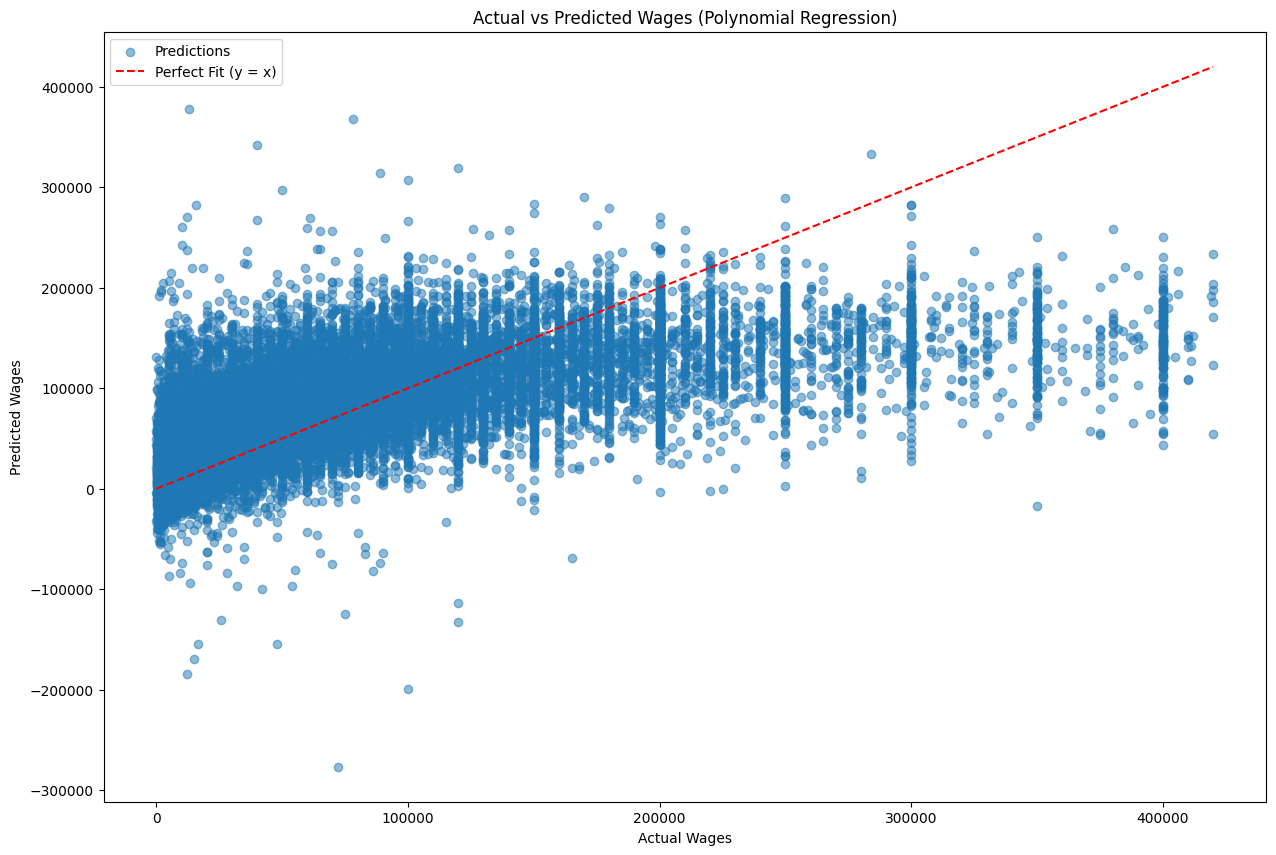

In [132]:
dfPR = df.copy()
X = dfPR.drop(columns = ['WAGP', 'SERIALNO', 'SCIENGP', 'SCIENGRLP'])
Y = dfPR['WAGP']
# drop remaining NaN values which are from SCHL
X = X.dropna()
Y = Y[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
degree = 3  # Adjust degree, 3 is best based on code below
poly = PolynomialFeatures(degree=degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# fit the model
model = LinearRegression()
model.fit(X_train_poly, y_train)
#predict
y_pred = model.predict(X_test_poly)
# evaluate model
maePR3 = mean_absolute_error(y_test, y_pred)
msePR3 = mean_squared_error(y_test, y_pred)
r2PR3 = r2_score(y_test, y_pred)

print(f"Polynomial Regression (Degree {degree})")
print(f"Mean Squared Error: {msePR3:.2f}")
print(f"Mean Absolute Error: {maePR3:.2f}")
print(f"R² Score: {r2PR3:.2f}")

# plot
# for loop to print out plots with different degrees to show how increaseing/decreasing degrees affects accuracy?
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Fit (y = x)")
plt.xlabel("Actual Wages")
plt.ylabel("Predicted Wages")
plt.title("Actual vs Predicted Wages (Polynomial Regression)")
plt.legend()
plt.show()


### Tuning

In [38]:

degrees = [1, 2, 3, 4, 5]  # Try different degrees
best_degree = 1
best_score = float('-inf')

for degree in degrees:
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # Cross-validation
    scores = cross_val_score(model, X_train_poly, y_train, cv=5, scoring="r2")
    avg_score = np.mean(scores)
    
    print(f"Degree {degree}: R² Score = {avg_score:.4f}")
    
    if avg_score > best_score:
        best_score = avg_score
        best_degree = degree

print(f"\nBest Polynomial Degree: {best_degree}")


Degree 1: R² Score = 0.3126
Degree 2: R² Score = 0.3684
Degree 3: R² Score = 0.3774
Degree 4: R² Score = 0.3726
Degree 5: R² Score = 0.2004

Best Polynomial Degree: 3


In [ ]:
# Train a simple linear model to get feature importance
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Get feature importance 
feature_importance = np.abs(linear_model.coef_)
important_features = pd.Series(feature_importance, index=X.columns).sort_values(ascending=False)

print("Feature Importance Ranking:")
print(important_features)

# Keep only top N important features 
top_features = important_features[:10].index.tolist()
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]


Feature Importance Ranking:
SEX        17058.893783
SCHL        7070.009060
ESR         6676.037088
SPORDER     5413.131673
COW         3828.637361
WKHP        1630.392011
RAC1P        631.713502
AGEP         502.225252
OCCP           3.813039
INDP           1.848543
SOCP           0.202646
NAICSP         0.002403
dtype: float64


Polynomial Regression (Degree 7)
Mean Squared Error: 9598018944.73
Mean Absolute Error: 44817.11
R² Score: -0.73


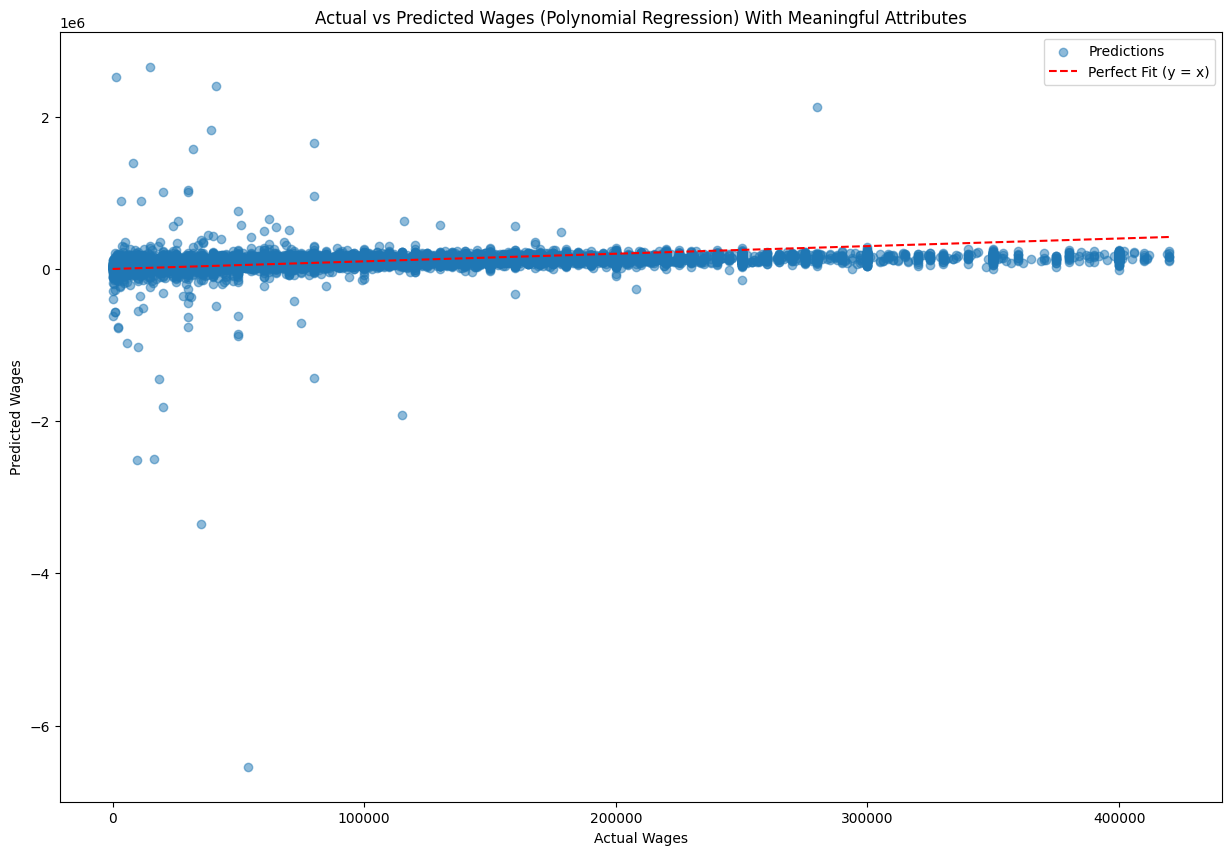

In [133]:
# polynomial regression with meaningful attrs
dfPR = df.copy()
meaningful_attrs = ['SEX', 'SCHL', 'ESR', 'SPORDER', 'COW', 'WKHP', 'RAC1P', 'AGEP']
X = dfPR[meaningful_attrs]
Y = dfPR['WAGP']
# drop remaining NaN values which are from SCHL
X = X.dropna()
Y = Y[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
degree = 7  # Adjust degree, 
poly = PolynomialFeatures(degree=degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# fit the model
model = LinearRegression()
model.fit(X_train_poly, y_train)
#predict
y_pred = model.predict(X_test_poly)
# evaluate model
maePR = mean_absolute_error(y_test, y_pred)
msePR = mean_squared_error(y_test, y_pred)
r2PR = r2_score(y_test, y_pred)

print(f"Polynomial Regression (Degree {degree})")
print(f"Mean Squared Error: {msePR:.2f}")
print(f"Mean Absolute Error: {maePR:.2f}")
print(f"R² Score: {r2PR:.2f}")

# plot
# for loop to print out plots with different degrees to show how increaseing/decreasing degrees affects accuracy?
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Fit (y = x)")
plt.xlabel("Actual Wages")
plt.ylabel("Predicted Wages")
plt.title("Actual vs Predicted Wages (Polynomial Regression) With Meaningful Attributes")
plt.legend()
plt.show()


## Neural Network - WIP

In [70]:
# drop serial no, sciengp, sciengrlp then dropna
# loss was extremely high - scale x train using minmaxscaler since data inst normally distributed
scaler = MinMaxScaler()

X = df.drop(columns=['WAGP', 'SERIALNO', 'SCIENGP', 'SCIENGRLP'])  
y = df['WAGP']
X = X.dropna()
y = y[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Standardize 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define  neural network model
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Input layer matching feature size
    layers.Dense(64, activation='relu'),  # Hidden layer with 64 neurons
    layers.Dense(32, activation='relu'),  # Hidden layer with 32 neurons
    layers.Dense(16, activation='relu'),  # Hidden layer with 16 neurons
    layers.Dense(1)  # Output layer for regression 
])

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae:.2f}")

# Make predictions
y_pred = model.predict(X_test)

# Convert predictions and actual values into DataFrame 
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
print(results.head())

Epoch 1/100
2804/2804 [==============================] - 18s 5ms/step - loss: 4955828736.0000 - mae: 47567.0469 - val_loss: 3538752000.0000 - val_mae: 40465.0547
Epoch 2/100
2804/2804 [==============================] - 14s 5ms/step - loss: 3408285440.0000 - mae: 40052.3398 - val_loss: 3497676288.0000 - val_mae: 40215.5156
Epoch 3/100
2804/2804 [==============================] - 12s 4ms/step - loss: 3385722880.0000 - mae: 39899.2891 - val_loss: 3481234432.0000 - val_mae: 40243.0312
Epoch 4/100
2804/2804 [==============================] - 11s 4ms/step - loss: 3373596160.0000 - mae: 39787.1953 - val_loss: 3480269568.0000 - val_mae: 40552.7422
Epoch 5/100
2804/2804 [==============================] - 11s 4ms/step - loss: 3365503488.0000 - mae: 39721.1797 - val_loss: 3459556608.0000 - val_mae: 40017.4414
Epoch 6/100
2804/2804 [==============================] - 12s 4ms/step - loss: 3357833728.0000 - mae: 39663.1289 - val_loss: 3457313024.0000 - val_mae: 40262.4102
Epoch 7/100
2804/2804 [=====

KeyboardInterrupt: 

In [67]:
X = df.copy()
X.head()
# drop serial no, sciengp, sciengrlp then dropna

,SERIALNO,SPORDER,WAGP,AGEP,COW,SCHL,SEX,WKHP,ESR,NAICSP,RAC1P,INDP,OCCP,SCIENGP,SCIENGRLP,SOCP
0,NaN,1,3600,19,1,NaN,2,16,1,7220,8,8680,4055,NaN,NaN,353023
1,NaN,1,800,23,1,NaN,1,15,1,7115,1,8564,2850,NaN,NaN,273043
2,NaN,1,1800,23,1,20.0,1,15,1,7115,1,8564,2850,NaN,NaN,273043
3,NaN,1,65000,28,1,NaN,1,40,6,4492,9,4796,4760,NaN,NaN,412031
4,NaN,1,3000,20,1,NaN,2,20,6,61101,2,7870,4640,NaN,NaN,399041


## Gradient Boosting

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost Regressor
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Train model
model.fit(X_train, y_train)

# Predict wages
y_pred = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 2648714839.111881


In [74]:

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1],
    'colsample_bytree': [0.7, 0.8, 1]
}

# Initialize model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(xgb_model, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


KeyboardInterrupt: 

## MLP Neural Net

In [93]:
dfMLP = df.copy()
dfMLP.head()
# drop serialno, sciengp, and sciengrlp since all Nan 
X = dfMLP.drop(columns = ['WAGP', 'SERIALNO', 'SCIENGP', 'SCIENGRLP'])
y = dfMLP['WAGP']
# drop remaining NaN values which are from SCHL
X = X.dropna()
y = y[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 1234)
# Standardize the Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build an MLP Model
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dense(8, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the Model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Set up Early Stopping for Faster Training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Model
history = model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test), 
    epochs=100, 
    batch_size=100,  # Optimal for speed
    verbose=1, 
    callbacks=[early_stopping]
)

# Evaluate Model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.2f}")


Epoch 1/100
898/898 [==============================] - 10s 6ms/step - loss: 12677855232.0000 - mae: 84353.1094 - val_loss: 12183631872.0000 - val_mae: 82873.4844
Epoch 2/100
898/898 [==============================] - 5s 5ms/step - loss: 12286004224.0000 - mae: 82755.4922 - val_loss: 11500239872.0000 - val_mae: 79971.8984
Epoch 3/100
898/898 [==============================] - 5s 5ms/step - loss: 11235030016.0000 - mae: 78279.0156 - val_loss: 10185445376.0000 - val_mae: 74182.9297
Epoch 4/100
898/898 [==============================] - 5s 5ms/step - loss: 9570041856.0000 - mae: 70684.4844 - val_loss: 8169253376.0000 - val_mae: 64472.9688
Epoch 5/100
898/898 [==============================] - 5s 6ms/step - loss: 7582333440.0000 - mae: 60614.8828 - val_loss: 6186074624.0000 - val_mae: 53535.3945
Epoch 6/100
898/898 [==============================] - 5s 5ms/step - loss: 5681488896.0000 - mae: 50071.8203 - val_loss: 4467762688.0000 - val_mae: 43665.6406
Epoch 7/100
898/898 [==================

KeyboardInterrupt: 

### Tuning

In [97]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

dfMLP = df.copy()
dfMLP.head()
# drop serialno, sciengp, and sciengrlp since all Nan 
X = dfMLP.drop(columns = ['WAGP', 'SERIALNO', 'SCIENGP', 'SCIENGRLP'])
y = dfMLP['WAGP']
# drop remaining NaN values which are from SCHL
X = X.dropna()
y = y[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 1234)
# Standardize the Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build an MLP Model
model = Sequential([
    Dense(32, input_shape=(X_train.shape[1],)),
    LeakyReLU(alpha=0.1),  
    BatchNormalization(),

    Dense(16),
    LeakyReLU(alpha=0.1),  
    BatchNormalization(),

    Dense(8),
    LeakyReLU(alpha=0.1),  # LeakyReLU 

    Dense(1)  
])

# Compile the Model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Set up Early Stopping for Faster Training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Model
history = model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test), 
    epochs=100, 
    batch_size=100,  
    verbose=1, 
    callbacks=[early_stopping]
)

# Evaluate Model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.2f}")



Epoch 1/100
898/898 [==============================] - 6s 3ms/step - loss: 12705932288.0000 - mae: 84472.5078 - val_loss: 12287875072.0000 - val_mae: 83345.0859
Epoch 2/100
898/898 [==============================] - 3s 3ms/step - loss: 12589977600.0000 - mae: 84098.7734 - val_loss: 12066991104.0000 - val_mae: 82648.1562
Epoch 3/100
898/898 [==============================] - 3s 3ms/step - loss: 12239538176.0000 - mae: 82878.0469 - val_loss: 11520366592.0000 - val_mae: 80551.7734
Epoch 4/100
898/898 [==============================] - 4s 4ms/step - loss: 11620922368.0000 - mae: 80584.1094 - val_loss: 10900403200.0000 - val_mae: 78333.5859
Epoch 5/100
898/898 [==============================] - 3s 4ms/step - loss: 10750611456.0000 - mae: 77167.0469 - val_loss: 9843332096.0000 - val_mae: 73658.5781
Epoch 6/100
898/898 [==============================] - 3s 4ms/step - loss: 9678361600.0000 - mae: 72660.1016 - val_loss: 8677635072.0000 - val_mae: 68533.8984
Epoch 7/100
898/898 [================

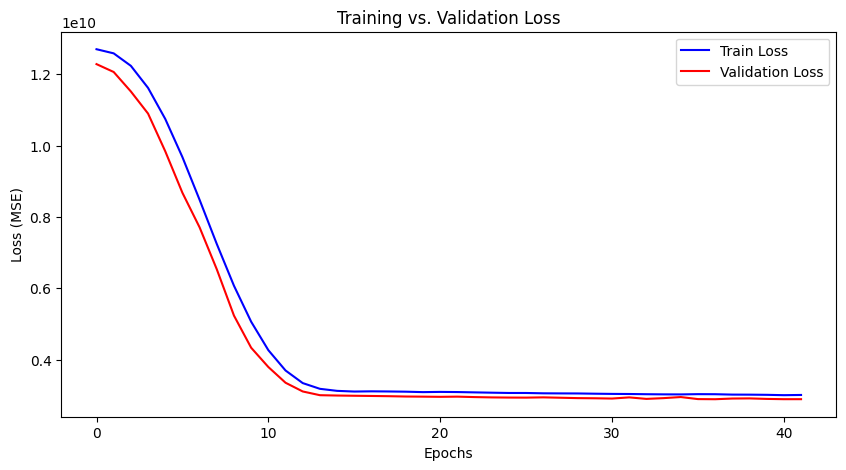

In [98]:
# training vs validation loss curve
plt.figure(figsize = (10,5))
plt.plot(history.history['loss'], label = 'Train Loss', color = 'blue')
plt.plot(history.history['val_loss'], label = 'Validation Loss', color = 'red')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

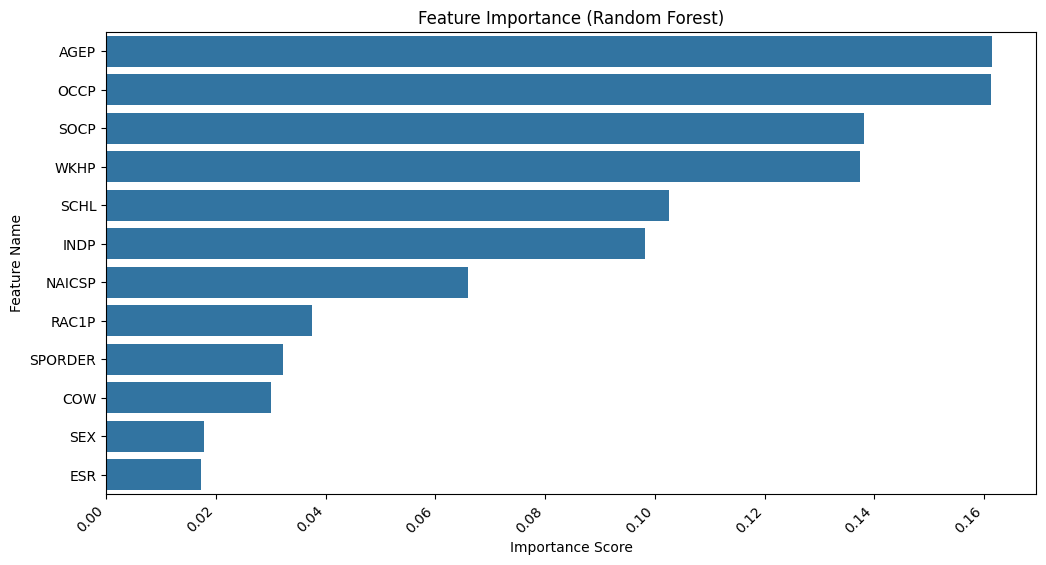

In [107]:
feature_names = df.columns.tolist()  
feature_names = [col for col in feature_names if col not in ['WAGP', 'SERIALNO', 'SCIENGP', 'SCIENGRLP']]

# Train Random Forest for feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get Feature Importances
feature_importances = rf.feature_importances_

# Create DataFrame for Visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 6))
sns.barplot(y=feature_importance_df['Feature'], x=feature_importance_df['Importance'])
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.title("Feature Importance (Random Forest)")

# Improve readability
plt.xticks(rotation=45, ha='right')  # Rotate feature names for readability
plt.show()


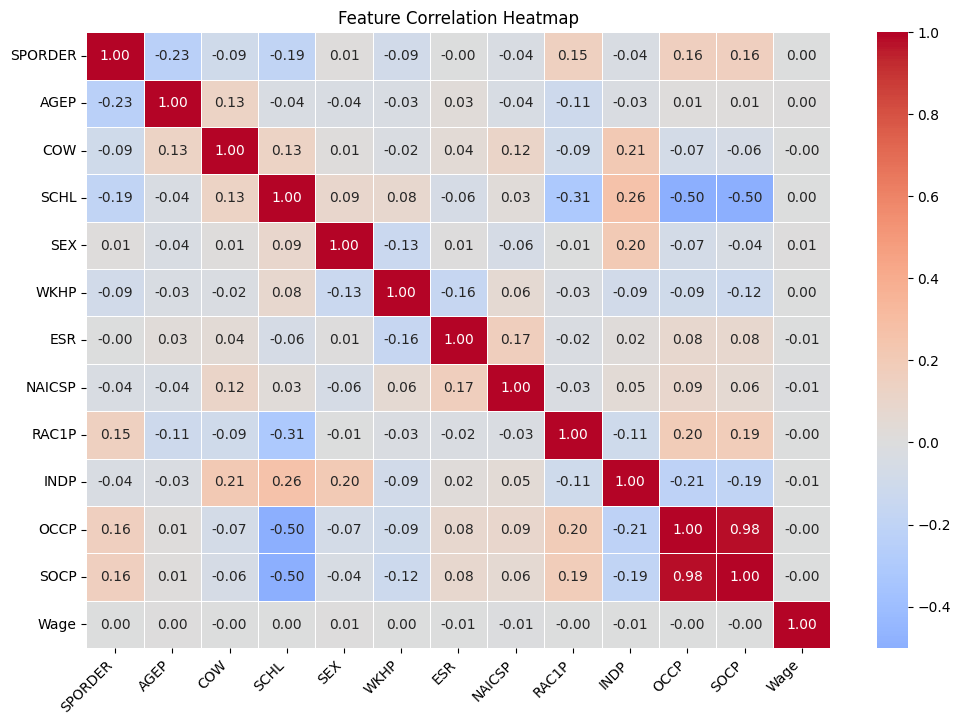

In [106]:
feature_names = df.columns.tolist()  
feature_names = [col for col in feature_names if col not in ['WAGP', 'SERIALNO', 'SCIENGP', 'SCIENGRLP']]

df_train = pd.DataFrame(X_train, columns=feature_names)
df_train['Wage'] = y_train  

#  Correlation Matrix
corr = df_train.corr()

#  Heatmap 
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5)

#  readability
plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)
plt.title("Feature Correlation Heatmap")

plt.show()


In [137]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

dfMLP = df.copy()
dfMLP.head()
# drop serialno, sciengp, and sciengrlp since all Nan 
X = dfMLP.drop(columns = ['WAGP', 'SERIALNO', 'SCIENGP', 'SCIENGRLP', 'ESR', 'SEX', 'COW', 'SPORDER', 'RAC1P', 'NAICSP'])
y = dfMLP['WAGP']
# drop remaining NaN values which are from SCHL
X = X.dropna()
y = y[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 1234)
# Standardize the Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build an MLP Model
model = Sequential([
    Dense(32, input_shape=(X_train.shape[1],)),
    LeakyReLU(alpha=0.1),  
    BatchNormalization(),

    Dense(16),
    LeakyReLU(alpha=0.1),  
    BatchNormalization(),

    Dense(8),
    LeakyReLU(alpha=0.1),  # LeakyReLU 

    Dense(1)  
])

# Compile the Model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Set up Early Stopping for Faster Training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Model
history = model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test), 
    epochs=100, 
    batch_size=100,  
    verbose=1, 
    callbacks=[early_stopping]
)

# Evaluate Model
loss, maeMLP = model.evaluate(X_test, y_test)
mseMLP = mean_squared_error(y_test, y_pred)
rmseMLP = np.sqrt(mseMLP)
print(f"Test MAE: {maeMLP:.2f}")
print(f"Test MSE: {mseMLP:.2f}")
print(f"Test RMSE: {rmseMLP:.2f}")
y_pred = model.predict(X_test)
r2MLP = r2_score(y_test, y_pred)
print(f"R² Score: {r2MLP:.4f}")



Epoch 1/100
898/898 [==============================] - 14s 11ms/step - loss: 12686761984.0000 - mae: 84396.1562 - val_loss: 12211591168.0000 - val_mae: 83020.5078
Epoch 2/100
898/898 [==============================] - 4s 5ms/step - loss: 12338911232.0000 - mae: 83096.1562 - val_loss: 11575255040.0000 - val_mae: 80598.1484
Epoch 3/100
898/898 [==============================] - 4s 4ms/step - loss: 11318727680.0000 - mae: 79117.5312 - val_loss: 10094406656.0000 - val_mae: 74463.1797
Epoch 4/100
898/898 [==============================] - 4s 4ms/step - loss: 9682605056.0000 - mae: 72265.8203 - val_loss: 8192560128.0000 - val_mae: 65791.7578
Epoch 5/100
898/898 [==============================] - 4s 4ms/step - loss: 7749233664.0000 - mae: 63274.0508 - val_loss: 6453876736.0000 - val_mae: 56949.0039
Epoch 6/100
898/898 [==============================] - 5s 5ms/step - loss: 5944286208.0000 - mae: 54082.1016 - val_loss: 4735214592.0000 - val_mae: 48177.6484
Epoch 7/100
898/898 [=================

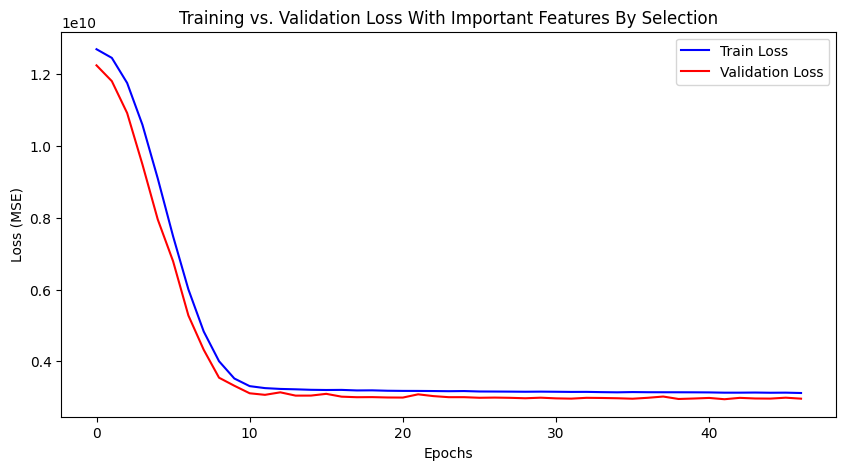

In [126]:
# training vs validation loss curve
plt.figure(figsize = (10,5))
plt.plot(history.history['loss'], label = 'Train Loss', color = 'blue')
plt.plot(history.history['val_loss'], label = 'Validation Loss', color = 'red')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training vs. Validation Loss With Important Features By Selection')
plt.legend()
plt.show()

## Model Comparison

In [127]:
r2_1000 = r2_score(y_test, y_pred1000)  
r2_100 = r2_score(y_test, y_pred100)
r2 = r2_score(y_test, y_pred)
print("K Nearest Neigbbors")
print("KNN With 10 Neighbors")
print(f"R-squared for KNN with 10 neighbors: {r2:.4f}")
print(f"MAE for KNN with 10 neighbors: {mae10}")
print(f"MSE for KNN with 10 neighbors: {mse10}")
print(f"RMSE for KNN with 10 neighbors: {rmse10}")
print("KNN With 100 Neighbors")
print(f"R-squared for KNN with 100 neighbors: {r2_100:.4f}")
print(f"MAE for KNN with 100 neighbors: {mae1000}")
print(f"MSE for KNN with 100 neighbors: {mse100}")
print(f"RMSE for KNN with 100 neighbors: {rmse100}")
print("KNN With 1000 Neighbors")
print(f"R-squared for KNN with 1000 neighbors: {r2_1000:.4f}")
print(f"MAE for KNN with 1000 neighbors: {mae1000}")
print(f"MSE for KNN with 1000 neighbors: {mse1000}")
print(f"RMSE for KNN with 1000 neighbors: {rmse1000}")
print('--------------------------------------------')
print("Decision Tree Regressor")
print(f"Mean Absolute Error (MAE): {maeTree:.2f}")
print(f"Mean Squared Error (MSE): {mseTree:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmseTree:.2f}")
print(f"R² Score: {r2Tree:.2f}")
print(f"Cross-Validated R² Scores: {r2Tree_scores}")
print(f"Mean R² Score: {r2Tree_scores.mean():.2f}")
print('--------------------------------------------')
print("Polynomial Regression")
print("3 degrees")
print(f"Test MSE: {msePR3:.2f}")
print(f"R² Score: {r2PR3:.4f}")
print("7 degrees")
print(f"Test MSE: {msePR:.2f}")
print(f"R² Score: {r2PR:.4f}")
print('--------------------------------------------')
print("MLP Neural Network")
print(f"Test MAE: {maeMLP:.2f}")
print(f"R² Score: {r2MLP:.4f}")


K Nearest Neigbbors
KNN With 10 Neighbors
R-squared for KNN with 10 neighbors: 0.4504
MAE for KNN with 10 neighbors: 37441.47510255039
MSE for KNN with 10 neighbors: 3064620061.2357125
RMSE for KNN with 10 neighbors: 55359.01065983489
KNN With 100 Neighbors
R-squared for KNN with 100 neighbors: 0.3759
MAE for KNN with 100 neighbors: 66375.1171872659
MSE for KNN with 100 neighbors: 3056354079.8887477
RMSE for KNN with 100 neighbors: 55284.30229177852
KNN With 1000 Neighbors
R-squared for KNN with 1000 neighbors: -0.3132
MAE for KNN with 1000 neighbors: 66375.1171872659
MSE for KNN with 1000 neighbors: 7438614972.127753
RMSE for KNN with 1000 neighbors: 86247.40559650333
--------------------------------------------
Decision Tree Regressor
Mean Absolute Error (MAE): 40133.93
Mean Squared Error (MSE): 3401474838.64
Root Mean Squared Error (RMSE): 58322.16
R² Score: 0.37
Cross-Validated R² Scores: [0.37447972 0.37656092 0.38461913 0.37921928 0.36614725]
Mean R² Score: 0.38
-----------------

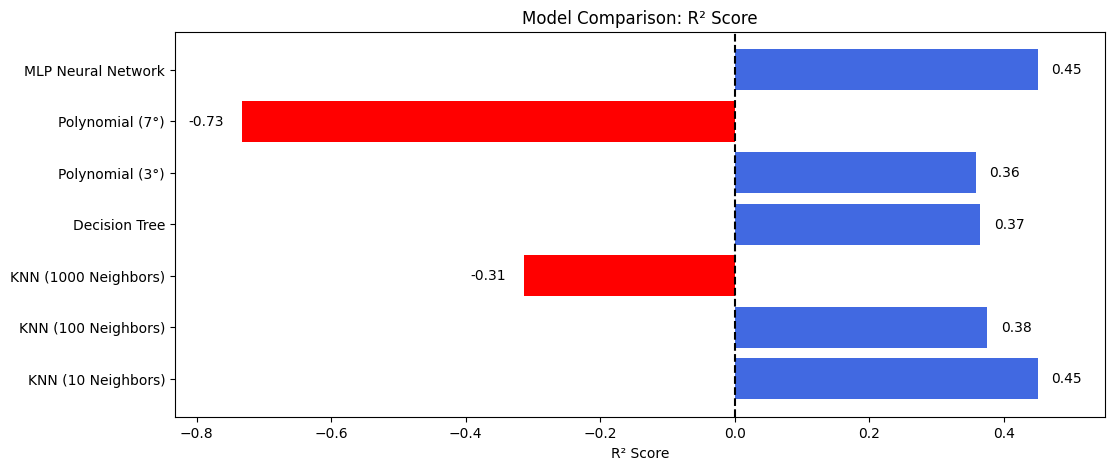

In [129]:


# Model names
models = [
    "KNN (10 Neighbors)", "KNN (100 Neighbors)", "KNN (1000 Neighbors)",
    "Decision Tree", "Polynomial (3°)", "Polynomial (7°)", "MLP Neural Network"
]


r2_scores = [r2, r2_100, r2_1000, r2Tree, r2PR3, r2PR, r2MLP]

# Find min and max R² to set proper axis limits
min_r2 = min(r2_scores) - 0.1  # Slight buffer for visibility
max_r2 = max(r2_scores) + 0.1

# Define colors: Red for negative R², Blue for positive
colors = ['red' if r < 0 else 'royalblue' for r in r2_scores]

# Plot R² Score with adjusted limits
plt.figure(figsize=(12, 5))
bars = plt.barh(models, r2_scores, color=colors)

# Set x-axis limits to include negative values
plt.xlim(min_r2, max_r2)

plt.xlabel("R² Score")
plt.title("Model Comparison: R² Score")

# Add text labels for each bar
for bar, r2 in zip(bars, r2_scores):
    plt.text(r2 + (0.02 if r2 >= 0 else -0.08), bar.get_y() + bar.get_height()/2, 
             f"{r2:.2f}", va='center', fontsize=10, color="black")

plt.axvline(x=0, color="black", linestyle="--")  # Mark R² = 0 line
plt.show()


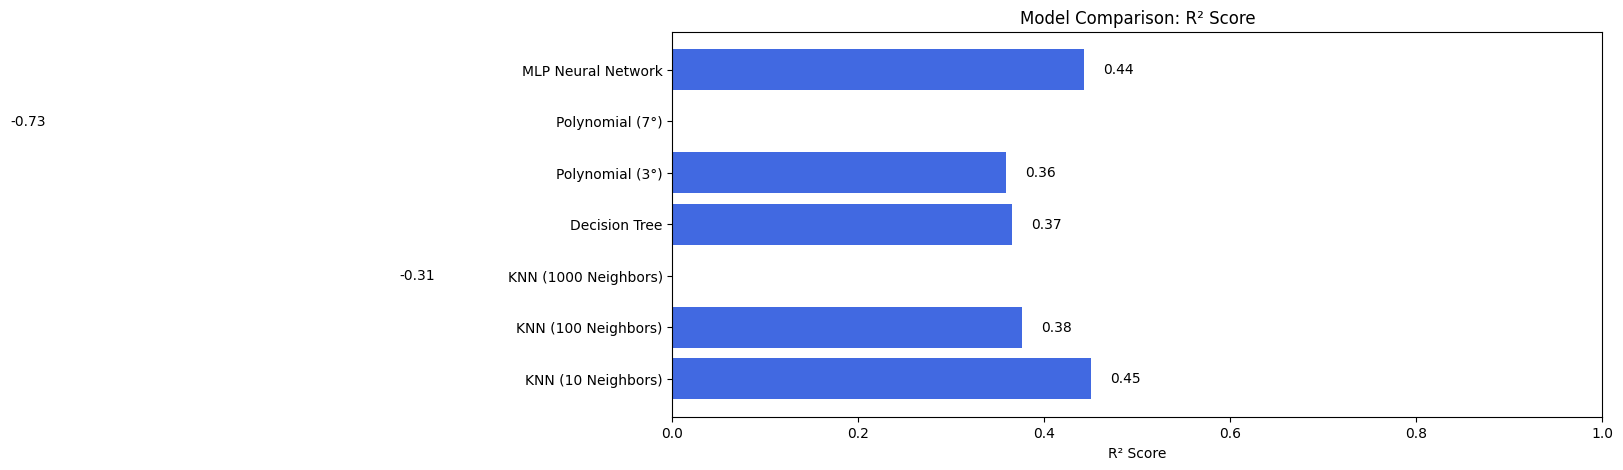

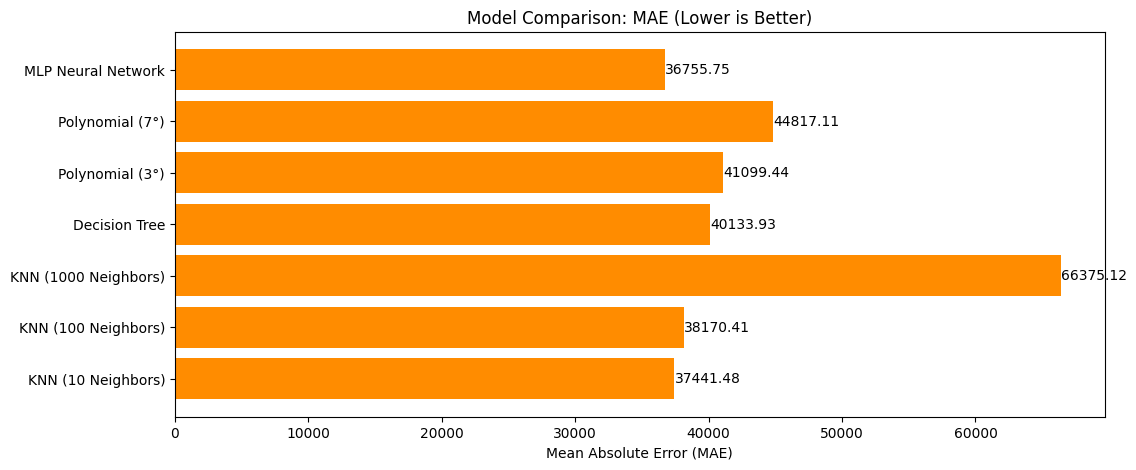

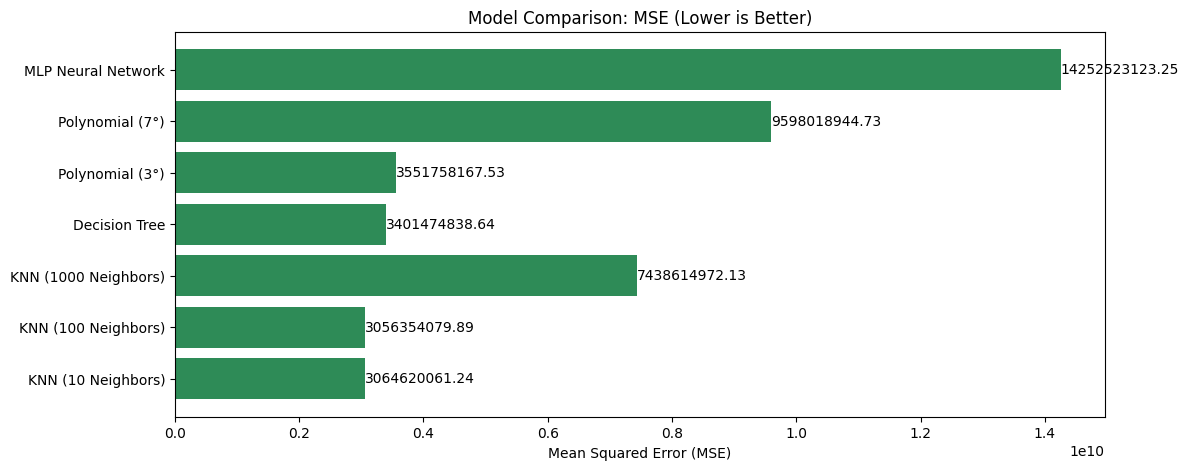

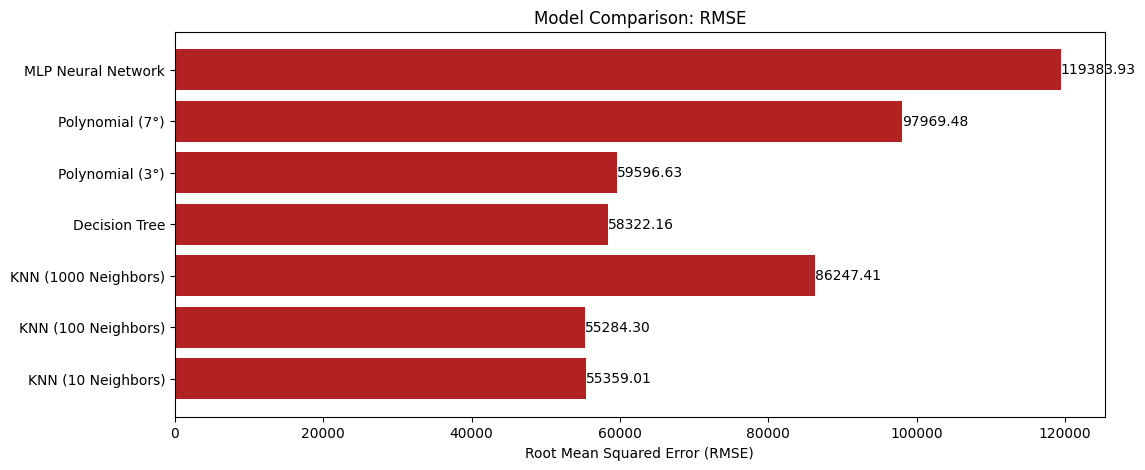

In [138]:

models = [
    "KNN (10 Neighbors)", "KNN (100 Neighbors)", "KNN (1000 Neighbors)",
    "Decision Tree", "Polynomial (3°)", "Polynomial (7°)", "MLP Neural Network"
]


r2_scores = [r2, r2_100, r2_1000, r2Tree, r2PR3, r2PR, r2MLP]
mae_scores = [mae10, mae100, mae1000, maeTree, maePR3, maePR, maeMLP]
mse_scores = [mse10, mse100, mse1000, mseTree, msePR3, msePR, mseMLP]
rmse_scores = [rmse10, rmse100, rmse1000, rmseTree, np.sqrt(msePR3), np.sqrt(msePR), rmseMLP]

# Convert None to NaN to avoid plotting issues
mae_scores = [x if x is not None else np.nan for x in mae_scores]
mse_scores = [x if x is not None else np.nan for x in mse_scores]
rmse_scores = [x if x is not None else np.nan for x in rmse_scores]

# Plot R² Score
plt.figure(figsize=(12, 5))
plt.barh(models, r2_scores, color='royalblue')
plt.xlabel("R² Score")
plt.title("Model Comparison: R² Score")
plt.xlim(0, 1)  # R² ranges between 0 and 1
for i, v in enumerate(r2_scores):
    plt.text(v + 0.02, i, f"{v:.2f}", va='center', fontsize=10)
plt.show()

# Plot MAE
plt.figure(figsize=(12, 5))
plt.barh(models, mae_scores, color='darkorange')
plt.xlabel("Mean Absolute Error (MAE)")
plt.title("Model Comparison: MAE (Lower is Better)")
for i, v in enumerate(mae_scores):
    plt.text(v + 0.02 if not np.isnan(v) else 0, i, f"{v:.2f}" if not np.isnan(v) else "", va='center', fontsize=10)
plt.show()

# Plot MSE
plt.figure(figsize=(12, 5))
plt.barh(models, mse_scores, color='seagreen')
plt.xlabel("Mean Squared Error (MSE)")
plt.title("Model Comparison: MSE (Lower is Better)")
for i, v in enumerate(mse_scores):
    plt.text(v + 0.02 if not np.isnan(v) else 0, i, f"{v:.2f}" if not np.isnan(v) else "", va='center', fontsize=10)
plt.show()

# Plot RMSE
plt.figure(figsize=(12, 5))
plt.barh(models, rmse_scores, color='firebrick')
plt.xlabel("Root Mean Squared Error (RMSE)")
plt.title("Model Comparison: RMSE")
for i, v in enumerate(rmse_scores):
    plt.text(v + 0.02 if not np.isnan(v) else 0, i, f"{v:.2f}" if not np.isnan(v) else "", va='center', fontsize=10)
plt.show()


In [139]:
df_metrics = pd.DataFrame({
    "Model": models,
    "R² Score": r2_scores,
    "MAE": mae_scores,
    "MSE": mse_scores,
    "RMSE": rmse_scores
})

# Display the DataFrame
print(df_metrics)

                  Model  R² Score           MAE           MSE           RMSE
0    KNN (10 Neighbors)  0.450409  37441.475103  3.064620e+09   55359.010660
1   KNN (100 Neighbors)  0.375925  38170.410231  3.056354e+09   55284.302292
2  KNN (1000 Neighbors) -0.313194  66375.117187  7.438615e+09   86247.405597
3         Decision Tree  0.365342  40133.934408  3.401475e+09   58322.164214
4       Polynomial (3°)  0.358956  41099.439638  3.551758e+09   59596.628827
5       Polynomial (7°) -0.732311  44817.107910  9.598019e+09   97969.479659
6    MLP Neural Network  0.442830  36755.753906  1.425252e+10  119383.931596


In [143]:
# Apply color coding to the DataFrame using a style function
def highlight_values(val):
    """Applies color coding to values based on their magnitude."""
    if isinstance(val, (int, float)):
        if "R² Score" in df_metrics.columns and val in df_metrics["R² Score"].values:
            color = 'lightgreen' if val > 0.8 else 'yellow' if val > 0.6 else 'lightcoral'
        elif "MAE" in df_metrics.columns and val in df_metrics["MAE"].values:
            color = 'lightgreen' if val < 2000 else 'yellow' if val < 4000 else 'lightcoral'
        elif "MSE" in df_metrics.columns and val in df_metrics["MSE"].values:
            color = 'lightgreen' if val < 20000 else 'yellow' if val < 40000 else 'lightcoral'
        elif "RMSE" in df_metrics.columns and val in df_metrics["RMSE"].values:
            color = 'lightgreen' if val < 150 else 'yellow' if val < 200 else 'lightcoral'
        else:
            color = 'white'
        return f'background-color: {color}'
    return ''

# Apply the styling function
styled_df = df_metrics.style.applymap(highlight_values)

print(styled_df)